In [26]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook, output_file
from bokeh.models import LinearAxis, Range1d, Span, HoverTool

In [27]:
df = pd.read_excel('ie_data.xls', sheet_name='Data', header=7)
df['Date'] = pd.to_datetime(df['Date'].map('{:.2f}'.format), format='%Y.%m')
df = df[['Date', 'Price', 'Dividend']].dropna()

In [28]:
df = df.loc[df.Date >= '1910']

In [29]:
prev_price, return_price = 1, 1
return_prices = []
for _, row in df.iterrows():
    return_price = (return_price/prev_price)*(row['Price'] + row['Dividend']/12)
    return_prices.append(return_price)
    prev_price = row['Price']
df['Return price'] = return_prices

In [30]:
years_to_lumpsum_info = {}

for nb_years in tqdm([5, 10, 15, 20, 25, 30]):
    return_dates, returns = [], []
    invest_start_prices, invest_end_prices = [], []
    for i in range(nb_years*12, len(df)):
        # investment 
        invest_row = df.iloc[i - nb_years*12]
        invest_start_prices.append(invest_row['Price'])
        invest_end_prices.append(df.iloc[i]['Price'])

        # returns
        enum = df.iloc[i]['Return price']
        denom = invest_row['Return price']
        returns.append(enum / denom)
        return_dates.append(df.iloc[i]['Date'])
        
    years_to_lumpsum_info[nb_years] = {
        'invest_start_prices': invest_start_prices,
        'invest_end_prices': invest_end_prices,
        'return_dates': return_dates,
        'returns': returns
    }

In [33]:
years_to_dca_info = {}

df_ordered = df.sort_values(by=['Date'], ascending=False)
for nb_years in tqdm([5, 10, 15, 20, 25, 30]): # [5, 10, 15, 20, 25, 30]):
    return_dates, returns = [], []
    
    for _, row in df_ordered.iterrows():
        _filter = (df['Date'] <= row['Date']) & \
            (df['Date'] >= row['Date'] - pd.DateOffset(years=nb_years))
        df_span = df_ordered.loc[_filter]
        if len(df_span) != nb_years*12 + 1:
            break
            
        _return = np.mean(df_span.iloc[0]['Return price'] / df_span['Return price'])
        return_dates.append(row['Date'])
        returns.append(_return)
        
    years_to_dca_info[nb_years] = {
        'return_dates': return_dates,
        'returns': returns
    }

#  Rolling returns across time

In [31]:
output_notebook()
# output_file('test.html')

Loading BokehJS ...

In [53]:
nb_roll_years = 5

# vars
lumpsum_return_dates = years_to_lumpsum_info[nb_roll_years]['return_dates']
lumpsum_returns = years_to_lumpsum_info[nb_roll_years]['returns']
invest_start_prices = years_to_lumpsum_info[nb_roll_years]['invest_start_prices']
invest_end_prices = years_to_lumpsum_info[nb_roll_years]['invest_end_prices']

dca_return_dates = years_to_dca_info[nb_roll_years]['return_dates']
dca_returns = years_to_dca_info[nb_roll_years]['returns']

# create plot
source = ColumnDataSource(data={
    'x': lumpsum_return_dates,
    'y': lumpsum_returns
})

hover = HoverTool(
    tooltips=[
        ("date", "@x{%F}"),
        ("y", "@y")
    ],
    formatters={
        "x": "datetime"
    },
    mode='vline'
)

p = figure(x_axis_label='Date', x_axis_type='datetime', y_axis_label='Rolling return', plot_width=900, tools=[hover])

p.y_range = Range1d(start=0, end=max(lumpsum_returns) + 1)
p.extra_y_ranges = {'price': Range1d(
    start=min(invest_end_prices), end=max(invest_end_prices))}
p.add_layout(LinearAxis(y_range_name='price', axis_label='Price'), 'right')

p.line('x', 'y', line_width=2, source=source, legend_label='Lumpsum rolling return')
p.line(dca_return_dates, dca_returns, line_width=2, color='purple', legend_label='Dca rolling return')
p.line(lumpsum_return_dates, invest_start_prices, visible=False, y_range_name='price', color='green', legend_label='Trailing price')
p.line(lumpsum_return_dates, invest_end_prices, y_range_name='price', color='red', legend_label='Current price')

hline = Span(location=1, dimension='width', line_color='black', line_width=1)
p.renderers.extend([hline])

p.legend.location = 'top_left'
p.legend.click_policy = 'hide'

show(p)

# Rolling returns stats

### Lump sum

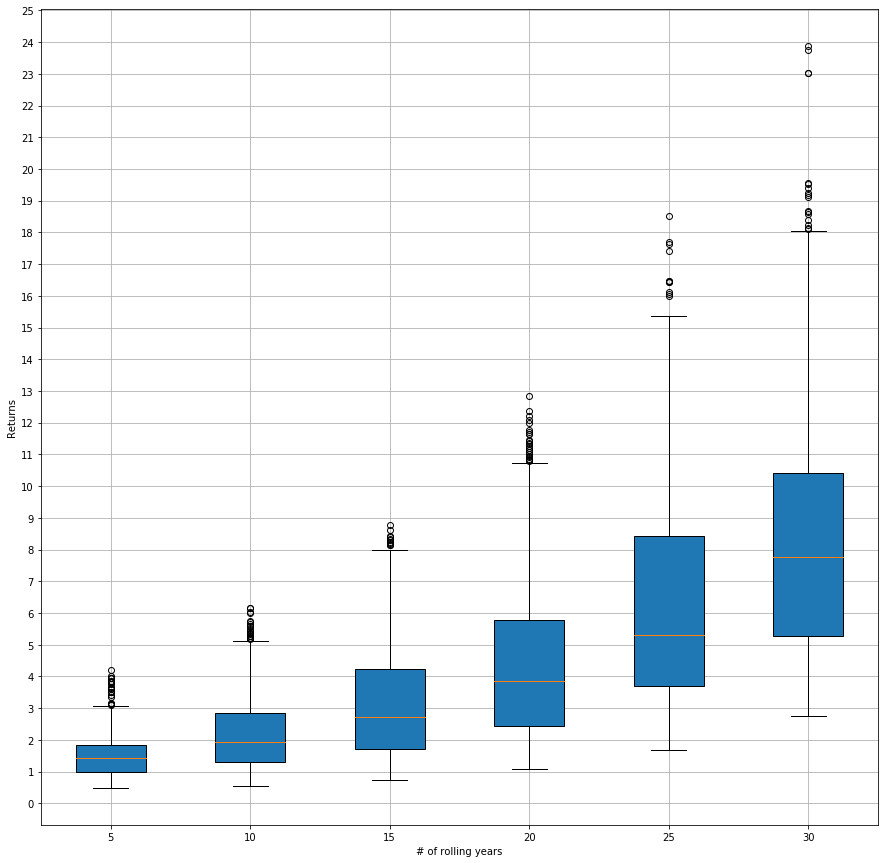

In [43]:
all_returns = [years_to_lumpsum_info[year]['returns'] for year in sorted(years_to_lumpsum_info.keys())]
plt.figure(figsize=(15, 15))
plt.boxplot(all_returns, patch_artist=True)
plt.xlabel('# of rolling years')
plt.ylabel('Returns')
plt.yticks(range(26), range(26))
plt.xticks(range(1, len(all_returns) + 1), sorted(years_to_info.keys()))
plt.grid()
plt.show()

### DCA

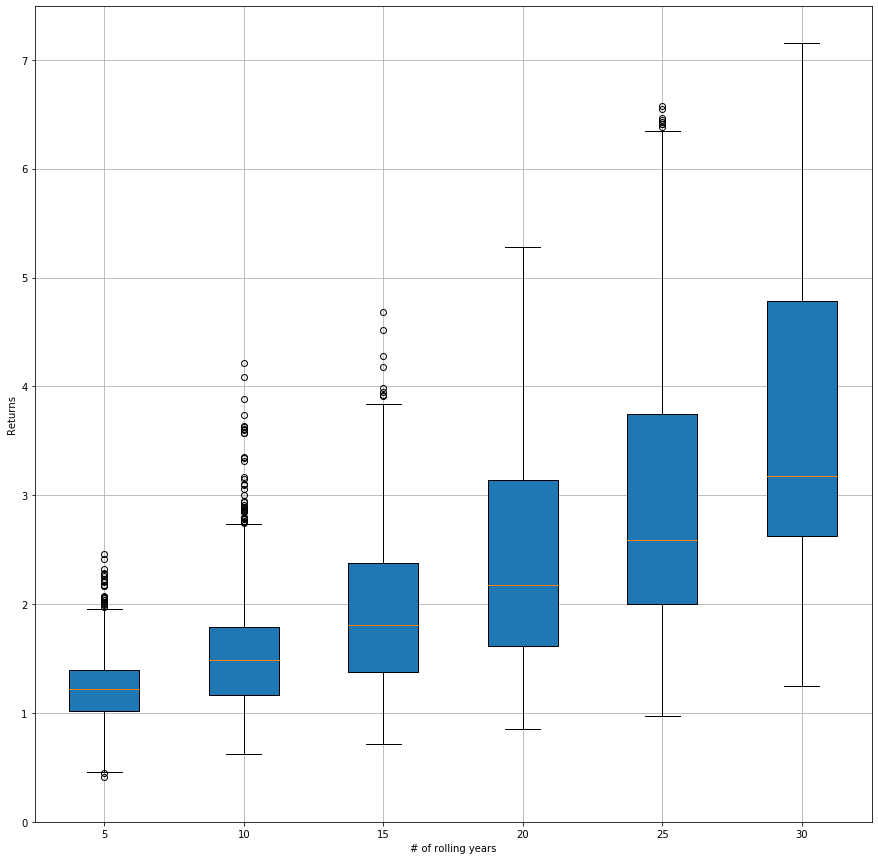

In [51]:
all_returns = [years_to_info[year]['returns'] for year in sorted(years_to_dca_info.keys())]
plt.figure(figsize=(15, 15))
plt.boxplot(all_returns, patch_artist=True)
plt.xlabel('# of rolling years')
plt.ylabel('Returns')
plt.yticks(range(8), range(8))
plt.xticks(range(1, len(all_returns) + 1), sorted(years_to_info.keys()))
plt.grid()
plt.show()